Surendar Raj M

21MM61R05


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import time
from torch import autograd
plt.style.use('default')

Gettting the dataset

In [19]:
transform =  transforms.ToTensor()


trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True) # Creating dataloader
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False) 

In [20]:
print('No. of samples in train set: '+str(len(train_loader.dataset)))
print('No. of samples in test set: '+str(len(test_loader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


In [21]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [22]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)    


In [23]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Encoder 

In [24]:
#Encoder
class Q_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss


Decoder

In [25]:
# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = self.lin3(x)
        return torch.sigmoid(x)

Discriminator

In [26]:
# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 2)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        return torch.sigmoid(self.lin3(x)) 

In [27]:
EPS = 1e-15
z_red_dims = 2
encoder = Q_net(784,1000,z_red_dims).to(device)
decoder = P_net(784,1000,z_red_dims).to(device)
Disc = D_net_gauss(500,z_red_dims).to(device)

In [28]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

In [29]:
#encode/decode optimizers
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=gen_lr)
#regularizing optimizers
optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=reg_lr)
optim_D = torch.optim.Adam(Disc.parameters(), lr=reg_lr)

Model with MSE Loss function

In [30]:
ae_criterion1 = nn.MSELoss()
num_epochs = 100
train_loss1 = []
disc_loss1=[]
train_acc1 = []
outputs = []

Training the model

In [31]:
def training(encoder, decoder, Disc, dataloader, optim_encoder, optim_decoder, optim_D,ae_criterion, train):
    total_rec_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    if train:
        encoder.train()
        decoder.train()
        Disc.train()
    else:
        encoder.eval()
        decoder.eval()
        Disc.eval()

    for i, (data, labels) in enumerate(dataloader):
        """ Reconstruction loss """
        for p in Disc.parameters():
            p.requires_grad = False

        real_data_v = autograd.Variable(data).to(device)
        real_data_v = real_data_v.view(-1, 784).to(device)
        #print(real_data_v.size())
        encoding = encoder(real_data_v).to(device)
        fake = decoder(encoding).to(device)
        ae_loss = ae_criterion(fake, real_data_v)
        total_rec_loss += ae_loss.item()
        cos = nn.CosineSimilarity(dim=1)
        output = torch.mean(cos(real_data_v,fake)).item()
        if train:
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()
            ae_loss.backward()
            optim_encoder.step()
            optim_decoder.step()
  
        """ Discriminator loss """
        encoder.eval()
        z_real_gauss = autograd.Variable(torch.randn(data.size()[0], 2) * 5.).to(device)
        D_real_gauss = Disc(z_real_gauss)

        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
        total_disc_loss += D_loss.item()

        if train:
            optim_D.zero_grad()
            D_loss.backward()
            optim_D.step()

        """ Generator loss """
        if train:
            encoder.train()
        else:
            encoder.eval()
        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        total_gen_loss += G_loss.item()

        if train:
            optim_encoder_reg.zero_grad()
            G_loss.backward()
            optim_encoder_reg.step()


        if i % 500 == 0:
            print ('\n Step [%d], recon_loss: %.4f, discriminator_loss :%.4f , generator_loss:%.4f'
                    %(i, ae_loss.item(), D_loss.item(), G_loss.item()))
            outputs.append((epoch, data, fake))

    M = len(dataloader.dataset)
    return total_rec_loss /M  , total_disc_loss /M , total_gen_loss /M,output


In [32]:
for epoch in range(num_epochs):
    l1,l2 ,l3,l4 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D,ae_criterion1, True)
    print('\n epoch:{} ---- training loss:{} ---- training accuracy:{}'.format((epoch+1), l1,l4))
    train_loss1.append(l1)
    disc_loss1.append(l2)
    train_acc1.append(l4)



 Step [0], recon_loss: 0.2335, discriminator_loss :1.4330 , generator_loss:0.6745

 Step [500], recon_loss: 0.0583, discriminator_loss :1.4038 , generator_loss:0.6283

 epoch:1 ---- training loss:0.0009826346549515923 ---- training accuracy:0.7262967824935913

 Step [0], recon_loss: 0.0530, discriminator_loss :1.4735 , generator_loss:0.6306

 Step [500], recon_loss: 0.0511, discriminator_loss :1.4399 , generator_loss:0.6251

 epoch:2 ---- training loss:0.0008192558318376542 ---- training accuracy:0.7318741679191589

 Step [0], recon_loss: 0.0518, discriminator_loss :1.4073 , generator_loss:0.6334

 Step [500], recon_loss: 0.0499, discriminator_loss :1.4409 , generator_loss:0.6328

 epoch:3 ---- training loss:0.0007896559627726674 ---- training accuracy:0.741930365562439

 Step [0], recon_loss: 0.0492, discriminator_loss :1.4882 , generator_loss:0.6263

 Step [500], recon_loss: 0.0473, discriminator_loss :1.5113 , generator_loss:0.6358

 epoch:4 ---- training loss:0.0007726864479482174

plotting the input image and the reconstucted image

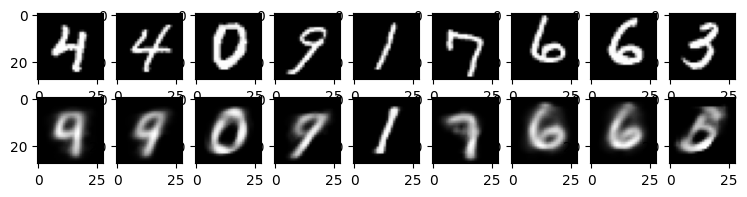

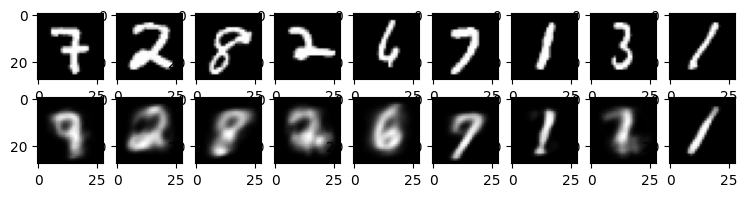

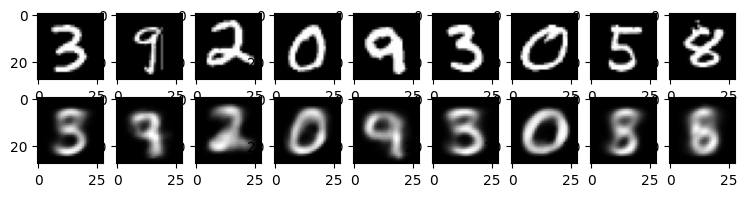

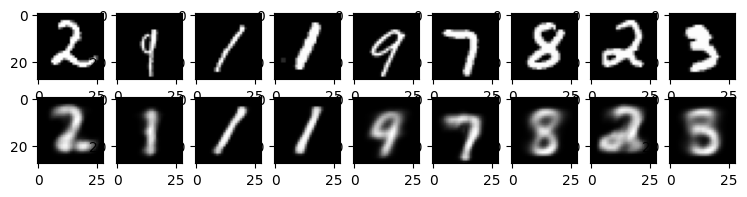

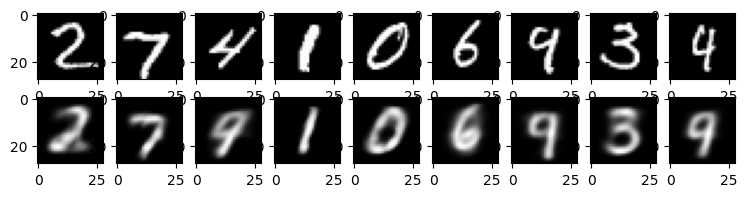

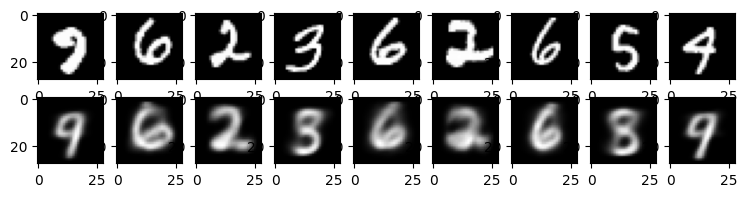

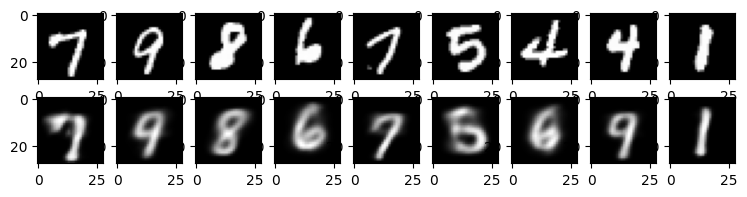

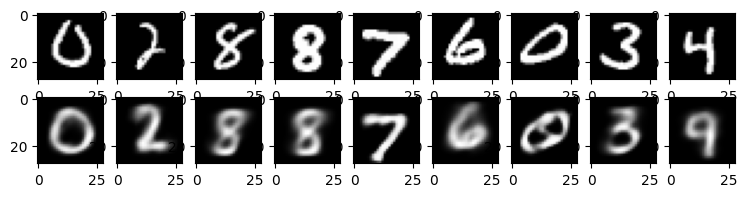

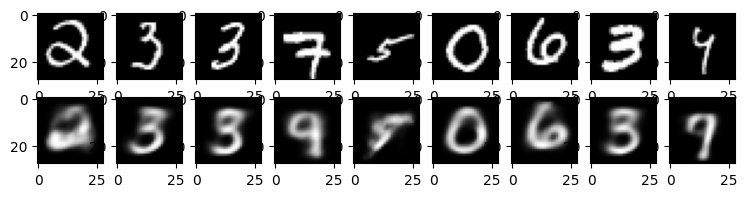

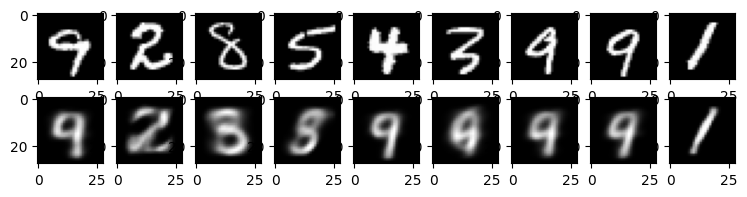

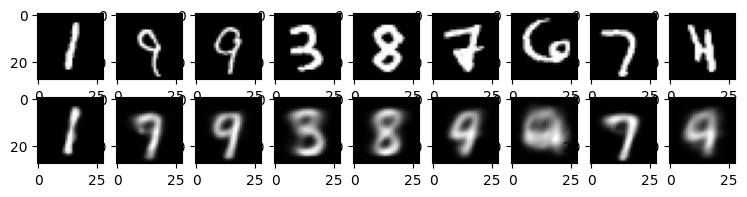

In [38]:
for k in range(0,num_epochs+10,10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

Plotting the losses for each epoch

Text(0, 0.5, 'Training')

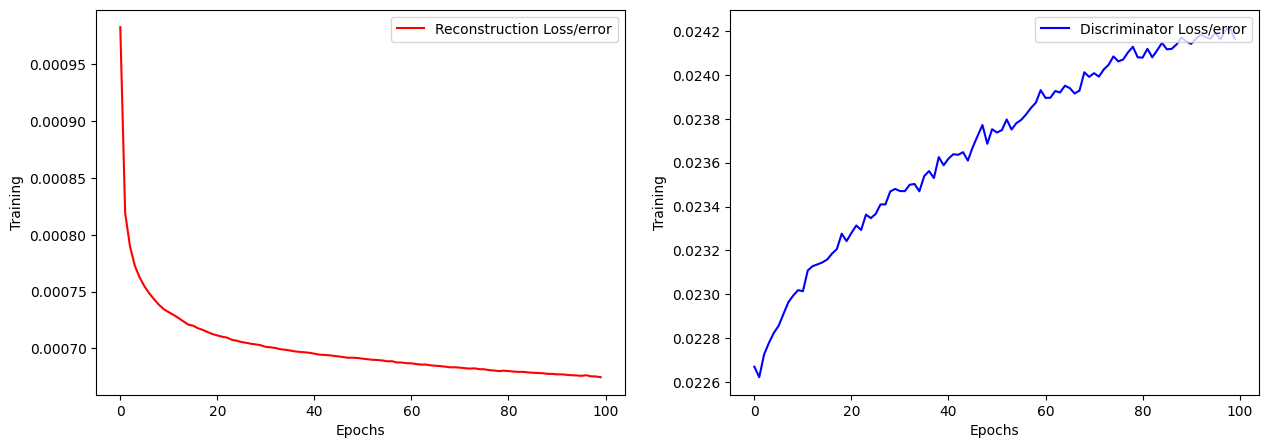

In [34]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss1,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),disc_loss1,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

Model with BCE Loss Function

In [35]:
ae_criterion2 = nn.BCELoss()
train_loss2 = []
disc_loss2=[]
train_acc2 = []
outputs = []

In [36]:
for epoch in range(num_epochs):
    l1,l2 ,l3,l4 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D,ae_criterion2,True)
    print('\n epoch:{} ---- training loss:{} ---- training accuracy:{}'.format((epoch+1), l1,l4))
    train_loss2.append(l1)
    disc_loss2.append(l2)
    train_acc2.append(l4)


 Step [0], recon_loss: 0.1940, discriminator_loss :1.5282 , generator_loss:0.5708

 Step [500], recon_loss: 0.1925, discriminator_loss :1.4980 , generator_loss:0.5856

 epoch:1 ---- training loss:0.0030374223026136556 ---- training accuracy:0.798017144203186

 Step [0], recon_loss: 0.1762, discriminator_loss :1.5456 , generator_loss:0.6459

 Step [500], recon_loss: 0.2103, discriminator_loss :1.5260 , generator_loss:0.6501

 epoch:2 ---- training loss:0.0030157817790905633 ---- training accuracy:0.7584409713745117

 Step [0], recon_loss: 0.1856, discriminator_loss :1.5493 , generator_loss:0.5986

 Step [500], recon_loss: 0.1819, discriminator_loss :1.5393 , generator_loss:0.5532

 epoch:3 ---- training loss:0.0030135472623010477 ---- training accuracy:0.78236985206604

 Step [0], recon_loss: 0.1841, discriminator_loss :1.4854 , generator_loss:0.6473

 Step [500], recon_loss: 0.1867, discriminator_loss :1.5825 , generator_loss:0.5844

 epoch:4 ---- training loss:0.0030099475050965946 -

Plotting the input and reconstructed image

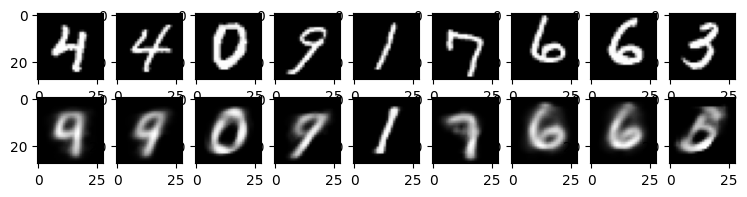

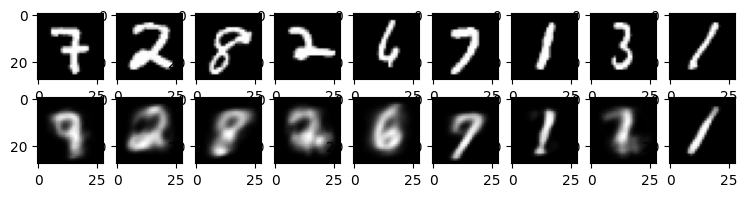

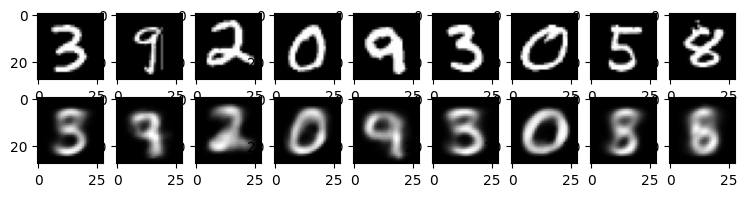

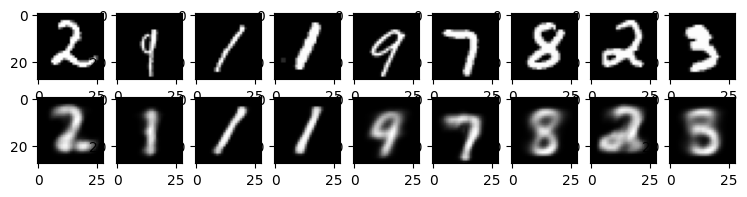

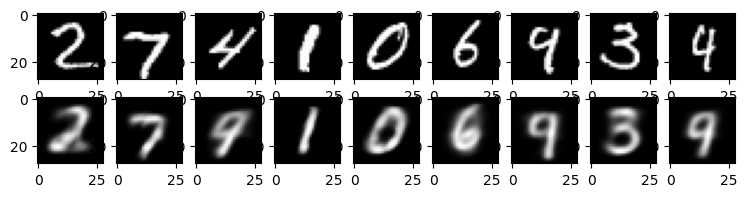

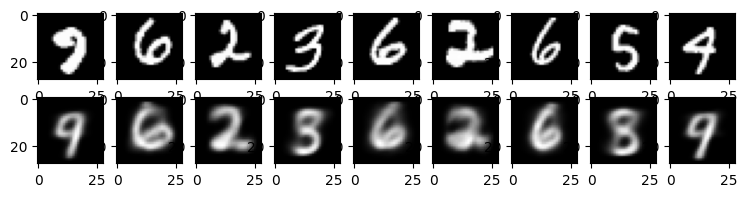

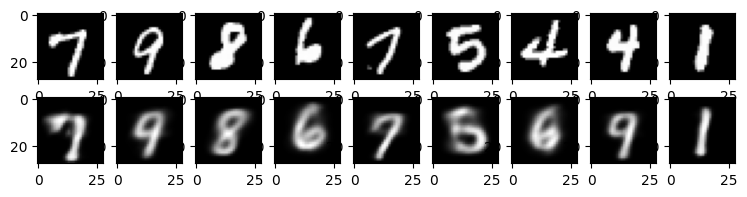

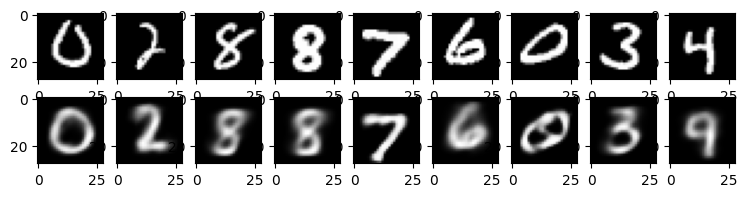

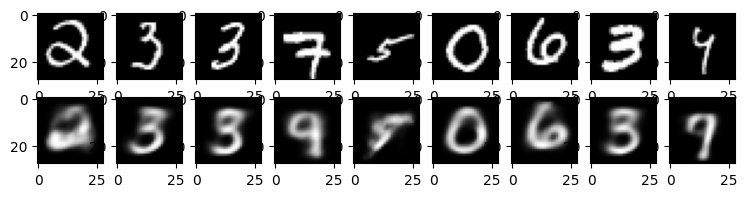

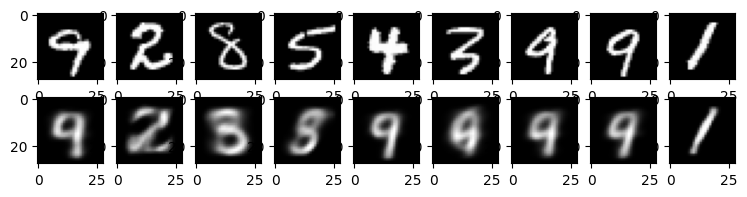

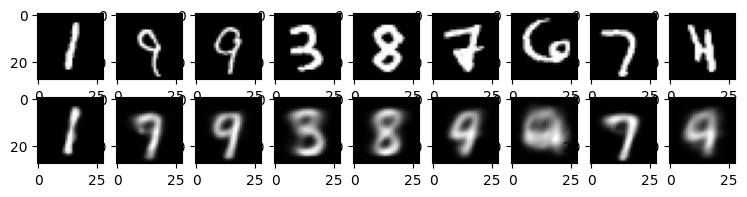

In [37]:
for k in range(0,num_epochs+10,10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

Plotting the losses for each epoch

Text(0, 0.5, 'Training')

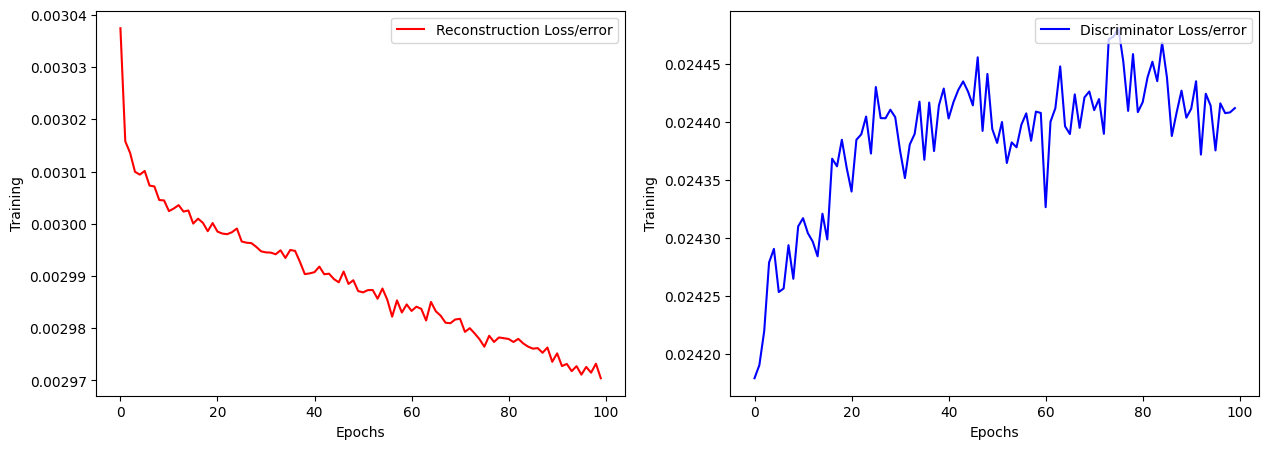

In [39]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss2,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),disc_loss2,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

In [40]:
pip install piqa

Model with SSIM Loss function

In [41]:
from piqa import SSIM

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

In [42]:
train_loss3 = []
disc_loss3=[]
train_acc3 = []
outputs = []
ae_criterion3 = SSIMLoss(n_channels=1).to(device)

In [43]:
def training1(encoder, decoder, Disc, dataloader, optim_encoder, optim_decoder, optim_D, train):
    total_rec_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    if train:
        encoder.train()
        decoder.train()
        Disc.train()
    else:
        encoder.eval()
        decoder.eval()
        Disc.eval()

    for i, (data, labels) in enumerate(dataloader):
        """ Reconstruction loss """
        for p in Disc.parameters():
            p.requires_grad = False

        real_data_v = autograd.Variable(data).to(device)
        real_data_v = real_data_v.view(-1, 784).to(device)
        #print(real_data_v.size())
        encoding = encoder(real_data_v).to(device)
        fake = decoder(encoding).to(device)
        img1=fake.unsqueeze(0)
        img1=img1.unsqueeze(0)
        img2=real_data_v.unsqueeze(0)
        img2=img2.unsqueeze(0)
        ae_loss = ae_criterion3(img1,img2)
        total_rec_loss += ae_loss.item()
        cos = nn.CosineSimilarity(dim=1)
        output = torch.mean(cos(real_data_v,fake)).item()
        if train:
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()
            ae_loss.backward()
            optim_encoder.step()
            optim_decoder.step()

        """ Discriminator loss """
        encoder.eval()
        z_real_gauss = autograd.Variable(torch.randn(data.size()[0], 2) * 5.).to(device)
        D_real_gauss = Disc(z_real_gauss)

        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
        total_disc_loss += D_loss.item()

        if train:
            optim_D.zero_grad()
            D_loss.backward()
            optim_D.step()

        """ Generator loss """
        if train:
            encoder.train()
        else:
            encoder.eval()
        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        total_gen_loss += G_loss.item()

        if train:
            optim_encoder_reg.zero_grad()
            G_loss.backward()
            optim_encoder_reg.step()


        if i % 500 == 0:
            print ('\n Step [%d], recon_loss: %.4f, discriminator_loss :%.4f , generator_loss:%.4f'
                    %(i, ae_loss.item(), D_loss.item(), G_loss.item()))
            outputs.append((epoch, data, fake))

    M = len(dataloader.dataset)
    return total_rec_loss /M  , total_disc_loss /M , total_gen_loss /M,output

In [44]:
for epoch in range(num_epochs):
    l1,l2 ,l3,l4 = training1(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D, True)
    print('\n epoch:{} ---- training loss:{} ---- training accuracy:{}'.format((epoch+1), l1,l4))
    train_loss3.append(l1)
    disc_loss3.append(l2)
    train_acc3.append(l4)


 Step [0], recon_loss: 0.4007, discriminator_loss :1.5708 , generator_loss:0.6527

 Step [500], recon_loss: 0.3626, discriminator_loss :1.6019 , generator_loss:0.6427

 epoch:1 ---- training loss:0.00537245815594991 ---- training accuracy:0.7814369797706604

 Step [0], recon_loss: 0.3329, discriminator_loss :1.5301 , generator_loss:0.6235

 Step [500], recon_loss: 0.3543, discriminator_loss :1.5253 , generator_loss:0.6122

 epoch:2 ---- training loss:0.005296099682648977 ---- training accuracy:0.7759626507759094

 Step [0], recon_loss: 0.3183, discriminator_loss :1.4935 , generator_loss:0.5877

 Step [500], recon_loss: 0.3440, discriminator_loss :1.5814 , generator_loss:0.5658

 epoch:3 ---- training loss:0.005264982501665751 ---- training accuracy:0.7962504625320435

 Step [0], recon_loss: 0.3230, discriminator_loss :1.5516 , generator_loss:0.6235

 Step [500], recon_loss: 0.3336, discriminator_loss :1.4872 , generator_loss:0.6251

 epoch:4 ---- training loss:0.005251918628811836 ---

plotting the input image and the reconstructed image

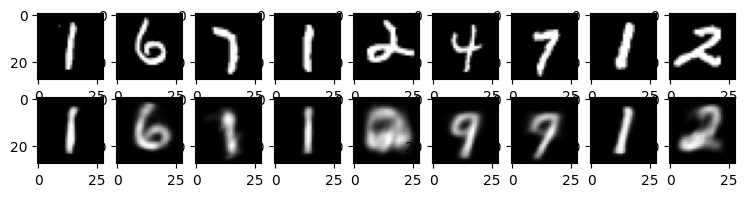

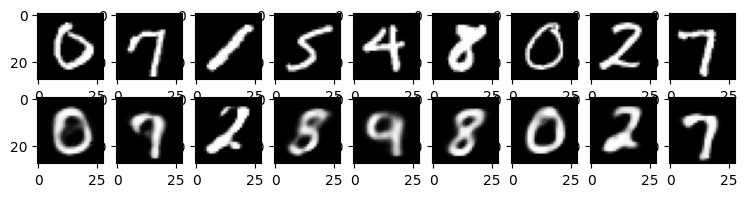

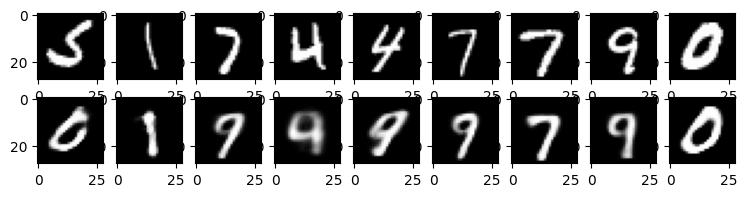

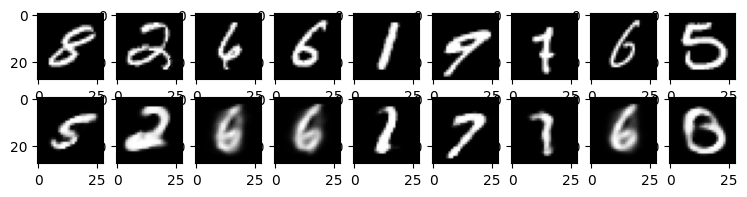

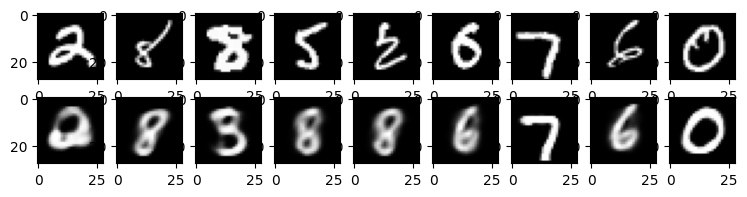

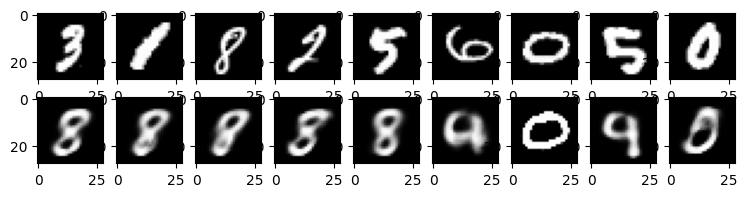

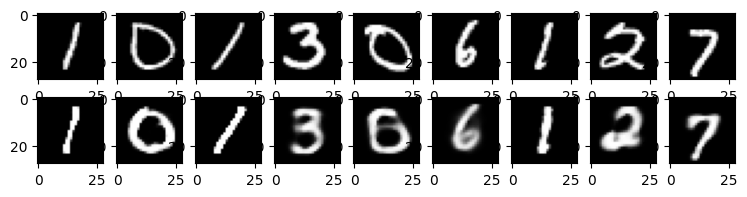

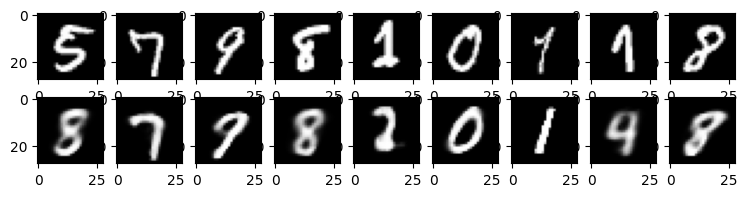

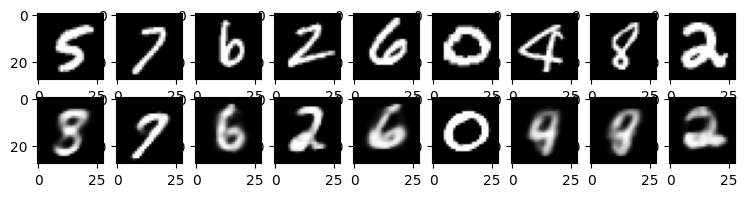

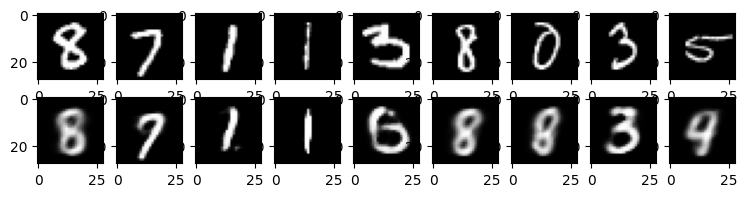

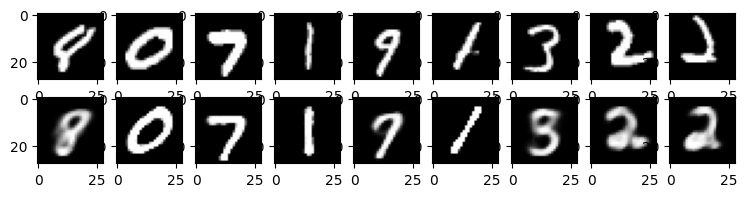

In [45]:
for k in range(0,num_epochs+10,10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

Plotting the losses for each epoch

Text(0, 0.5, 'Training')

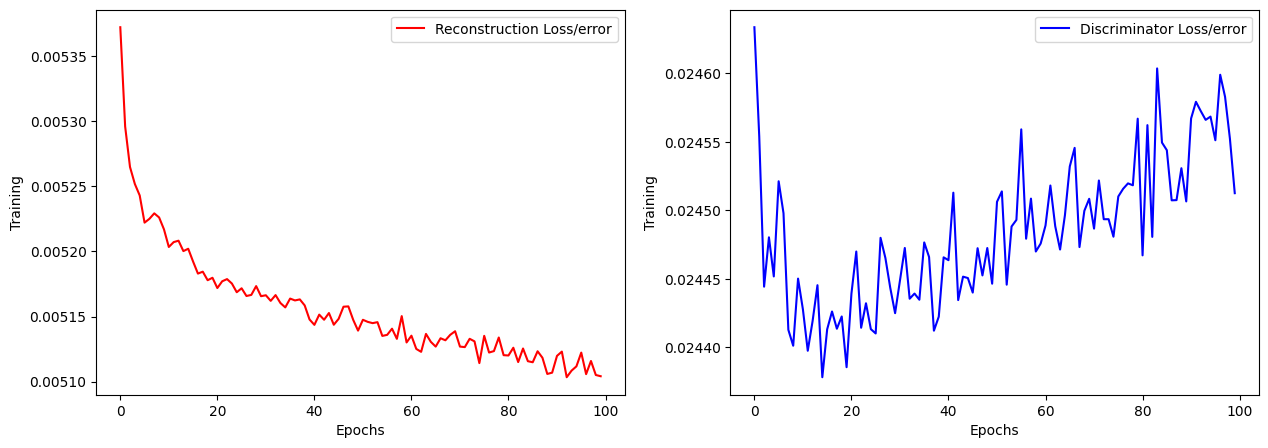

In [46]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss3,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),disc_loss3,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

plotting the training accuracy and the losses per epoch for all three loss functions respectively





Text(0, 0.5, 'Loss')

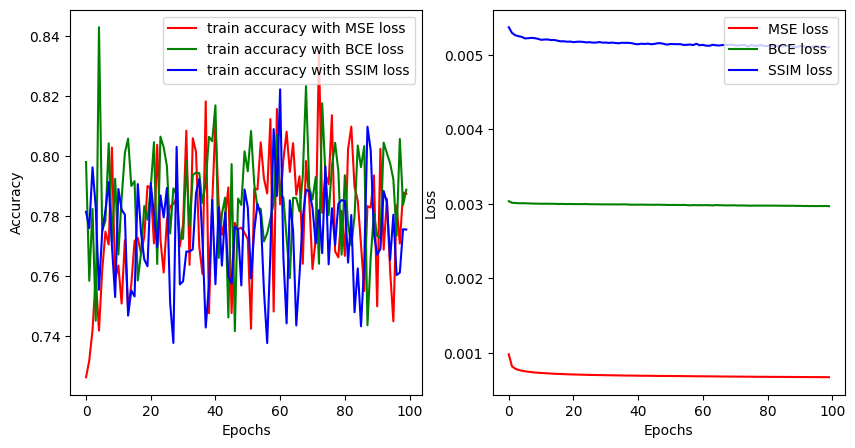

In [49]:
fig = plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(range(num_epochs),train_acc1,'r-',label='train accuracy with MSE loss') 
plt.plot(range(num_epochs),train_acc2,'g-',label='train accuracy with BCE loss') 
plt.plot(range(num_epochs),train_acc3,'b-',label='train accuracy with SSIM loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(range(num_epochs),train_loss1,'r-',label='MSE loss') 
plt.plot(range(num_epochs),train_loss2,'g-',label='BCE loss') 
plt.plot(range(num_epochs),train_loss3,'b-',label='SSIM loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')


Q2)  comment on the losses graph

ans:
     the reconstruction loss decreases over epoch and converges after some time ,but the discriminator loss initailly decreased with epochs and then started to increase with each epoch

Q3) Write the entire training process of the vanilla adversarial autoencoder in brief and con-cise3-5 step algorithm.

ans:

the training process of the Adversarial autoencoder is quite similar to GAN and is carried out in following way:
1. Firstly the encoder and decoder part of whole AAE is trained to reduce recontruction loss. 
	At this stage the Generator and Discriminator are neglected.
 	Then pass input to encoder which will result in a latent code and now this latent code will be fed to decoder .Using BAckpropgation weights will be updated such that recontruction loss get decreased


2. Unlike first part now train only Generator and Discrimaintor leaving the decoder untouched.Train the discriminator to classify the output from the genrator having required distributiuion and the encoder part .
	Upon training now our discriminator will learn to classify real images from generator and fake images from Encoder

3. Now by connecting the encoder output  to the discriminator input we will make sure that encoder learns the same distribution as that of the generator which had required distriibution to produce real images

4. Fix the  discriminator weights and target value as 1 (real image) and feed image to encoder and find discriminator output  .We will backpropgate only through the encopdcder to update weights of only encoder so that it lresarns the desired distribution and produce output  which will have that diostribution 




Algorithm:

1.Train Encoder and Decoder with optimizer and loss.

2.Fix weights of Decoder and train  discriminator, generator (with desirted distribution) and encoder.

3.Connect Encoder output to Discrtiminator input and train it keeping the discrimantor weights constant and target value as 1 (real image).

4.Now Encoder too learns the required distribtuion to generate fake images exacttly similar to real images.

5.Plot Accuracy and Loss results  

 

Q5) best loss function

ans:
 We observe that the Loss for MSE is having less variation as compared to other Loss function. And Gives more accurate convergence as compared to other Losses. We observe that SSIM loss is having less variation but convergence is not accurate. So, Most suggested is MSE Loss function.  